container_image = docker://jiakaiw/surfacesimulationtest:v10
universe = container

log = decode_$(Cluster).log
error = decode_$(Process).err
output = decode_result_$(Process).txt

executable = stim_run_python.sh
arguments = $(Process)

should_transfer_files = YES
when_to_transfer_output = ON_EXIT
transfer_input_files = $(Process).pkl, job.py

request_cpus = 1
request_memory = 2GB
request_disk = 2GB

queue 560









python3 job.py $1




.github/workflows/python-package.yml at a205418

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import qutip
import scqubits
from IPython.display import clear_output
import matplotlib as mpl

import sys
sys.path.append('../')
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems

In [2]:
def check_repeats(arr):
    flattened = arr.flatten()
    unique_elements, counts = np.unique(flattened, return_counts=True)
    duplicates = unique_elements[counts > 1]    
    return len(duplicates) > 0, duplicates

In [3]:
max_ql = 30
max_ol = 110
EJ = 3
EC = EJ/4
EL = EJ/20.5
Er = 8.46111172

g = 0.2
system  =  FluxoniumOscillatorSystem(
                EJ = EJ,
                EC = EC,
                EL = EL,
                Er = Er,
                g_strength = g,
                qubit_level = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
                computaional_states = '1,2',
                ) 

In [4]:
id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_fluxonium_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
fluxonium_creation_arr = id_wrapped_fluxonium_destory.dag().full()
fluxonium_destory_arr= id_wrapped_fluxonium_destory.full()

In [5]:
ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)

issue with going from (0, 52) to (0, 53)
issue with going from (7, 51) to (7, 52)
issue with going from (11, 21) to (11, 22)
issue with going from (16, 107) to (16, 108)
issue with going from (25, 106) to (25, 107)
issue with going from (29, 19) to (29, 20)


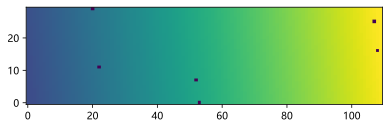

In [6]:
def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)
overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]
        if ol>=1 and system.product_to_dressed[(ql,ol)] != find_next_in_branch(system.product_to_dressed[(ql,ol-1)]):
            print(f"issue with going from {(ql,ol-1)} to {(ql,ol)}")
            diagonalization_idx_arr_with_marks[ql,ol] = -1000

        if ol < 1:
            overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        else:
            overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

plt.imshow(diagonalization_idx_arr_with_marks,origin='lower')

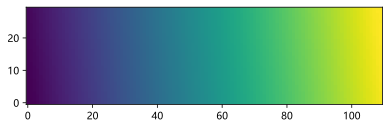

In [7]:
plt.imshow(overlap_idx_arr,origin='lower')

 /tmp/ipykernel_21247/2969237809.py: 8ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_21247/2969237809.py: 10ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_21247/2969237809.py: 21ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_21247/2969237809.py: 23

(0.0, 100.0)

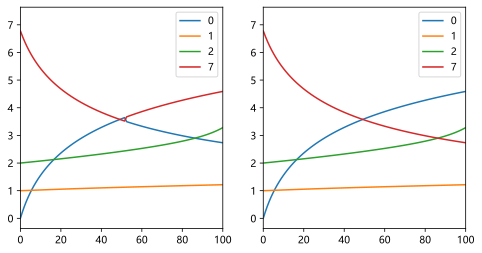

In [8]:
fig,axes = plt.subplots(1,2,figsize=(8,4))
for ql in [0,1,2,7]:
    dressed_idx_arr = diagonalization_idx_arr[ql]
    photon_num_arr = np.zeros((max_ol))
    fluxonium_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        state_after_a = resonator_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        photon_num_arr[ol] = np.sum(state_after_a**2)
        state_after_fluxnonium_a = fluxonium_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)

    axes[0].plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}')
axes[0].legend()

for ql in [0,1,2,7]:
    dressed_idx_arr = overlap_idx_arr[ql]
    photon_num_arr = np.zeros((max_ol))
    fluxonium_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        state_after_a = resonator_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        photon_num_arr[ol] = np.sum(state_after_a**2)
        state_after_fluxnonium_a = fluxonium_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)

    axes[1].plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}')
axes[1].legend()

axes[0].set_xlim(0,100)
axes[1].set_xlim(0,100)